# Profitable Google & Apple Apps Analysis

#### Goal: 
If a person wants to develop an app and list it on Google Play, what category and price should he choose? The person also plans to list this app on listed on App Store, if this app is successful on Google Play Store.

#### Result:
We will choose **GAME** as the category for the new developed app and if the developer's aim is to reach **10M+ installs**, then the app's price is recommended to be **below 1 dollar**. But if developer can be satisfied with installs between **100 ~ 10M+**, then the recommend price range would be **2 -4 dollars**. Since the category **'Games'** is also a popular category in **ios** paid apps, the price between 2- 4 dollars is also a reasonable price for a game app on ios store.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import warnings
from sklearn import preprocessing
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
apple = pd.read_csv("AppleStore.csv")
google = pd.read_csv("googleplaystore.csv")

In [4]:
apple.head()

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,284882215,Facebook,389879808,USD,0.0,2974676,212,3.5,3.5,95.0,4+,Social Networking,37,1,29,1
1,389801252,Instagram,113954816,USD,0.0,2161558,1289,4.5,4.0,10.23,12+,Photo & Video,37,0,29,1
2,529479190,Clash of Clans,116476928,USD,0.0,2130805,579,4.5,4.5,9.24.12,9+,Games,38,5,18,1
3,420009108,Temple Run,65921024,USD,0.0,1724546,3842,4.5,4.0,1.6.2,9+,Games,40,5,1,1
4,284035177,Pandora - Music & Radio,130242560,USD,0.0,1126879,3594,4.0,4.5,8.4.1,12+,Music,37,4,1,1


In [5]:
google.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Data Cleaning
- delete google 10473th row with wrong entry
- delete duplicate apps with lower reivews
- delete rows with non english apps
- remove rows with more than 5 na values

In [6]:
#wrong entry 
google.drop(10472, axis = 0, inplace = True)

In [7]:
#clean dataframe duplicates
def clean_df_dup(df, apps_col, rating_count):
    boo = df[apps_col].duplicated(False)
    dup_df = df[boo == True]
    clean_df = df[boo == False]
    
    for app in dup_df[apps_col].unique():
        a = dup_df[dup_df == app].sort_values(rating_count)
        clean_df = clean_df.append(a.iloc[0])
        
#     print(f'Original number of rows: {len(df)}')
#     print(f'Cleaned number of rows: {len(clean_df)}')
    
    return clean_df

#clean apps that are none english
def clean_non_eng(df, apps_col):
    clean_df = df.copy()
    for index, row in df.iterrows():     
        max_ch = []
        app = row[apps_col]
        
        for ch in str(app):
            if (ord(ch) > 127) or (ord(ch) < 0):
                max_ch.append(ord(ch))
             
        if len(max_ch) > 3:
            #print(f'drop {app}')
            clean_df.drop(index, inplace = True)
            
    print(f'Number of Non-English Apps: {len(df) - len(clean_df)}')
#     print(f'Cleaned number of rows: {len(clean_df)}')
        
    return clean_df

#remove NAN 
def clean_na(df, price_col, apps_col):
    clean_df = df.copy()
    clean_df.dropna(axis = 0, how = 'any',thresh = 6, inplace = True)
            
    print(f'Na rows removed: {len(df) - len(clean_df)}')
#     print(f'Cleaned number of rows: {len(clean_df)}')
    
    return clean_df

In [353]:
#apple -- clean duplicates -- clean non english apps -- clean na rows
apple_c3 = clean_na(clean_non_eng(clean_df_dup(apple, 'track_name', 'rating_count_ver'), 'track_name'), 'price', 'track_name')

Number of Non-English Apps: 1014
Na rows removed: 2


In [9]:
#google -- clean duplicates -- clean non english apps -- clean na rows
google_c3 =  clean_na(clean_non_eng(clean_df_dup(google, 'App', 'Reviews'),'App'), 'Type', 'App')

Number of Non-English Apps: 45
Na rows removed: 798


# Transform Columns
- change price, installs, size to numerical value
- drop unecessary columns for prediction
- form new variable ins_cat and reviews_cat from installs and reviews as categorical variables
- add new variable profit as price * installs
- separate price and free apps

In [10]:
#google-- free apps and priced apps 
google_c3['Rating_cat'] = round(google_c3['Rating']).astype('object')
#del unecessary columns
google_c3 = google_c3.drop(['Genres','Last Updated', 'Current Ver', 'Android Ver'], axis = 1)
#price trans
google_c3['Price'] = google_c3['Price'].str.replace('$', '').str.strip()
google_c3['Price'] = google_c3['Price'].astype('float')

#review trans
google_c3['Reviews'] = google_c3['Reviews'].astype('float')
des =  google_c3.describe().iloc[3:8, 1].values
google_c3['Reviews_cat'] = pd.cut(google_c3['Reviews'], bins = des, 
                                  labels = ['very low', 'low', 'medium', 'high'])
#installs transform 
google_c3['Installs_num'] = google_c3['Installs'].str.extract(r'([\d,]+)+').iloc[:,0].str.replace(',','').astype('float')
google_c3['Installs_cat'] = pd.cut(google_c3['Installs_num'], bins = [0.0, 1000.0, 100000.0, 10000000.0, np.inf], 
                              labels = ['0 ~1k','1k ~100k', '100k ~10M','10M+'])
#Size transform
def trans_Size(x):
    x = x.strip()
    if x[-1] == 'M':
        return float(x[:-1]) * 1000000
    elif x[-1] == 'k':
        return float(x[:-1]) * 1000
    else:
        return np.nan

google_c3['Size_num'] = google_c3['Size'].apply(trans_Size)

#profit - new variable
google_c3['Profit'] = google_c3['Installs_num'] * google_c3['Price']

#paid app percentage
def paid_perc(x):
    if x in a.index:
        return float(a.loc[[x],'Paid_perc'].values)
    else:
        return 0

a = google_c3.groupby('Category')['Type'].value_counts(
    normalize = True).to_frame().rename(columns ={'Type': 'Paid_perc'}).reset_index(level = 1)                                                                                           
a = a[a.Type == 'Paid'].sort_values('Paid_perc', ascending = False)

google_c3['Paid_percent'] = google_c3['Category'].map(paid_perc)

#separate price and free apps
priced_google = google_c3[(google_c3['Type'] != 'Free')]
free_google = google_c3[google_c3['Type'] == 'Free']

In [344]:
print(f'Number of apple apps: {len(apple_c3)}')
# print(f'Number of priced apple apps: {len(priced_apple)}')
# print(f'Number of free apple apps: {len(free_apple)}')



Number of apple apps: 6179


In [354]:
#drop unecessary columns
apple_c3 = apple_c3[['track_name', 'size_bytes', 'price', 'rating_count_tot','user_rating', 'prime_genre']]

#Rating Cat
apple_c3['Rating_cat'] = round(apple_c3['user_rating']).astype('object')

#apple -- free apps and priced apps
free_apple = apple_c3[apple_c3['price'] == 0.0]
priced_apple = apple_c3[apple_c3['price'] != 0.0]

# Exploratory Data Analysis For Google Store
- What are the features for a general app on google store? 
- What are the characteristics of a popular app?
- What is the relationship between variables?
- What are the top 10 categories with highest downloads?

In [12]:
#rating, review, and price -- mean, median
print(f'Number of google apps: {len(google_c3)}')
# print(f'Number of priced google apps: {len(priced_google)}')
# print(f'Number of free google apps: {len(free_google)}')

des = google_c3.describe()
pd.DataFrame(des.iloc[[1, 5 ],:])


Number of google apps: 8816


,Rating,Reviews,Price,Installs_num,Size_num,Profit,Paid_percent
mean,4.159076,99868.890653,1.101532,3.530484e+06,1.971252e+07,22951.161728,0.080547
50%,4.300000,604.000000,0.000000,5.000000e+04,1.100000e+07,0.000000,0.095406


A general app on google store are usually free and have Rating around 4.2, Review around 604, Installs around 1.8M and Size around 20M.

In [32]:
#many installs
pv_table_num = pd.pivot_table(data = google_c3, index = 'Installs', 
                              values = ['Rating', 'Reviews','Size_num','Installs_num','Price'
                                       ]).sort_values(['Installs_num', 'Rating', 'Reviews'], ascending = False)
pv_table_pop = pv_table_num.iloc[:5, :]
print(pd.DataFrame(pv_table_num.iloc[:4, :].mean(axis = 0), columns = ['Mean']))
pv_table_pop

                      Mean
Installs_num  4.125000e+08
Price         0.000000e+00
Rating        4.229549e+00
Reviews       5.746739e+06
Size_num      4.866719e+07


,Installs_num,Price,Rating,Reviews,Size_num
Installs,,,,,
"1,000,000,000+",1.000000e+09,0.000000,3.800000,1.169808e+06,NaN
"500,000,000+",5.000000e+08,0.000000,4.450000,1.714505e+07,7.000000e+07
"100,000,000+",1.000000e+08,0.000000,4.346429,3.450164e+06,4.302800e+07
"50,000,000+",5.000000e+07,0.000000,4.321769,1.221935e+06,3.297356e+07
"10,000,000+",1.000000e+07,0.001385,4.281818,3.316238e+05,3.252674e+07


1. If we assume an app with 50M+ above installs is a popular app. 
The popular apps are usually free with Rating of 4.23, Reviews around 575k, Installs around 413M, and Size around 48M.
2. The NaN in Size_num for 1B installs is because these apps vary in sizes on different devices. 

We can see that the popular apps have substantially higher reviews and larger size compared to general app. To validate the relationship between install with review and size we will look at their correlations.

<AxesSubplot:>

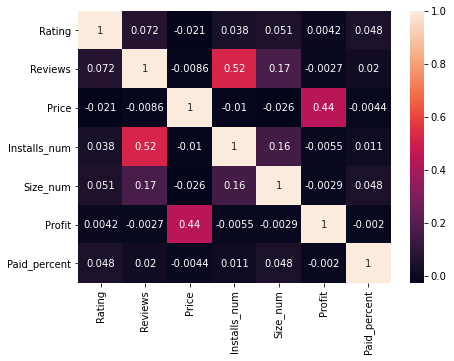

In [14]:
#correlation
plt.figure(figsize=(7,5))
sns.heatmap(google_c3.corr(), annot = True)

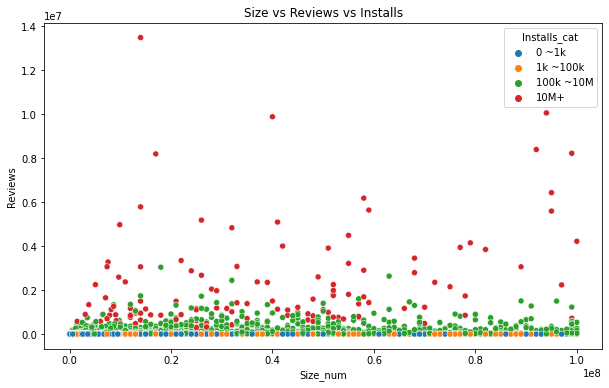

In [15]:
fig, axes = plt.subplots(figsize = (10, 6))
sns.scatterplot(data = google_c3, x = 'Size_num', y = 'Reviews', hue = 'Installs_cat', x_jitter= True,
    y_jitter= True, ax = axes)
plt.title("Size vs Reviews vs Installs")
plt.show()

1. From the heatmap, we see that there are positive correlation between installs and number of reviews and size of app, especially with number of reviews which has a correlation of 0.52. 
2.  Although we found that number of reviews has positive correlation 0.17 with size of the app. From the scatter plot, it is also possible that this number may be impacted by the postive correlation between number of installs with reviews and size separately.

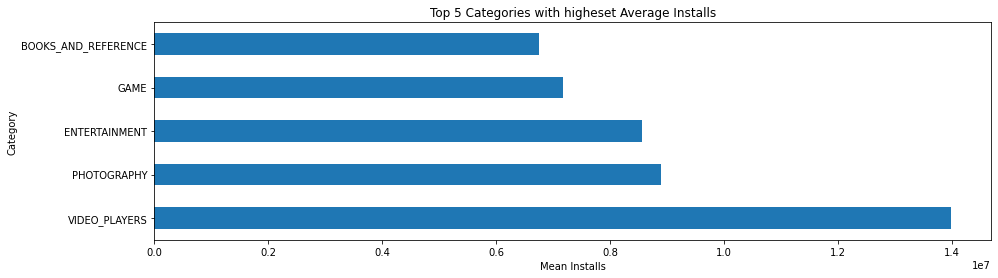

,Installs_num,Reviews
Category,,
VIDEO_PLAYERS,1.399212e+07,204362.263158
PHOTOGRAPHY,8.889085e+06,205624.032922
ENTERTAINMENT,8.553559e+06,189931.423729
GAME,7.171695e+06,268936.435807
BOOKS_AND_REFERENCE,6.748362e+06,54943.081340


In [51]:
#Find top 5 categories with highest installs

pv_table_cat_ins = pd.pivot_table(data= google_c3, index= 'Category', values = ['Installs_num', 'Reviews'], aggfunc = np.mean
                                 ).sort_values(['Installs_num', 'Reviews'], ascending = False)
top_5_all_ind = pv_table_cat_ins.index[:5].values
top_10_all_ind = pv_table_cat_ins.index[:10].values

plt.figure(figsize=(15,4))
pv_table_cat_ins[:5]['Installs_num'].plot(kind = 'barh')
plt.xlabel("Mean Installs")
plt.title('Top 5 Categories with higheset Average Installs')
plt.show()

pv_table_cat_ins[:5]

The top 5 categories with greatest installs are 'VIDEO_PLAYERS', 'PHOTOGRAPHY', 'ENTERTAINMENT', 'GAME', 'BOOKS_AND_REFERENCE'. 

# Compare between Price and Free Apps on Google Store
- What is the price range for most priced apps?
- Is rating affected by the price of app?
- What kind of Category have most priced apps?


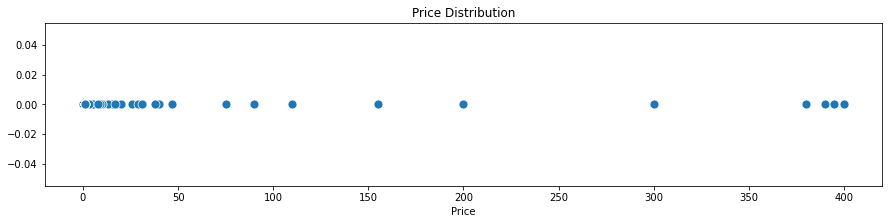

In [17]:
fig, axes = plt.subplots(figsize = (15, 3))
sns.scatterplot(x = priced_google['Price'], y = np.zeros(len(priced_google['Price'])), ax = axes, s = 80)
plt.title('Price Distribution')
plt.show()

Most priced apps charge between 0-50 dollars. The values with prices greater than 50 dollars will be discussed later.

Average rating of priced google apps: 4.26
Average rating of free google apps: 4.15


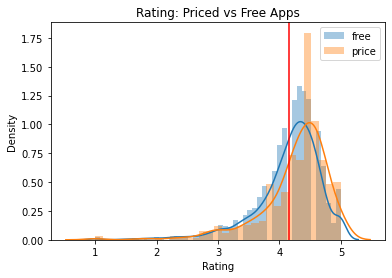

In [100]:
#rating
sns.distplot(free_google['Rating'], label = 'free')
sns.distplot(priced_google['Rating'], label = 'price').set_title('Rating: Priced vs Free Apps')
plt.axvline(x= google_c3['Rating'].mean(), c = 'red')
plt.legend()

print('Average rating of priced google apps: {}'.format(round(priced_google['Rating'].mean(),2)))
print('Average rating of free google apps: {}'.format(round(free_google['Rating'].mean(),2)))

Most priced apps have higher rating.

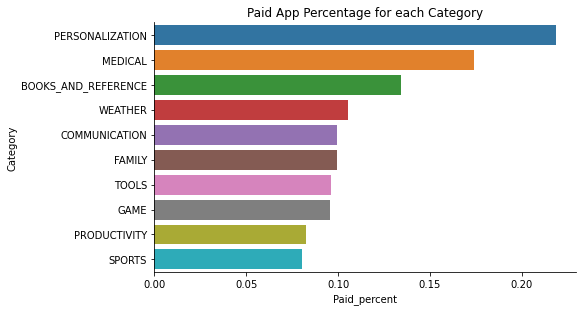

In [18]:
#Paid App Percentage
pv_table_perc = pd.pivot_table(data= google_c3, index = 'Category',
                                values = ['Paid_percent']).sort_values(['Paid_percent']
                                                                       ,ascending = False).reset_index('Category')

sns.catplot(data = pv_table_perc[pv_table_perc['Paid_percent'] > 0.08]
            , x = 'Paid_percent', y = 'Category', kind = 'bar', height = 4, aspect = 2)
plt.title('Paid App Percentage for each Category')
plt.show()

From the plot, we can see that personalization apps have the greatest percentage of charged apps compared to other categories.

# Find Category to Recommend
- What are the top 5 categories with the most number of installs for priced apps?
- What is the distribution of free and priced apps of these top 5 categories
- Does priced apps have overlapping categories for high average installs?

Mean
Installs_num    116958.293283
Paid_percent         0.076994
Price               26.761780
Profit          973031.757860
Reviews          10190.834270
dtype: float64


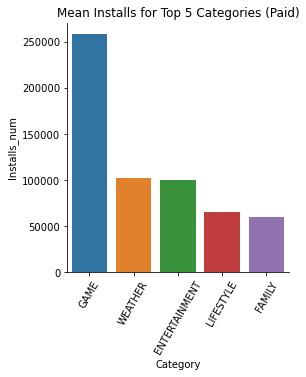

In [168]:
#top 5 categories with most downloads
pv_table_price = pd.pivot_table(data= priced_google, index = 'Category',
                                values = ['Installs_num', 'Price', 'Reviews', 'Paid_percent','Profit'
                                         ]).sort_values(['Installs_num','Paid_percent'], 
                                                        ascending = False)
top_5_priced_ind = pv_table_price.index[:5].values
top_10_priced_ind = pv_table_price.index[:10].values

print('Mean')
print(pv_table_price[:5].mean(axis = 0))

#plot
pv_table_price = pv_table_price[:5]['Installs_num'].reset_index(level = 0)
sns.catplot(data = pv_table_price, x = 'Category', y = 'Installs_num', kind = 'bar', height = 4)
plt.xticks(rotation = 60)
plt.title("Mean Installs for Top 5 Categories (Paid)")
plt.show()

1.The 5 categories with highest average installs are 'GAME', 'WEATHER', 'ENTERTAINMENT', 'LIFESTYLE', 'FAMILY'. The total average installs and price across these categories are 117k and \$26.76.

2.There are around 8\% of paid apps in each of these 5 categories
 
We will take a look at the distribution of free and priced apps of these categories.

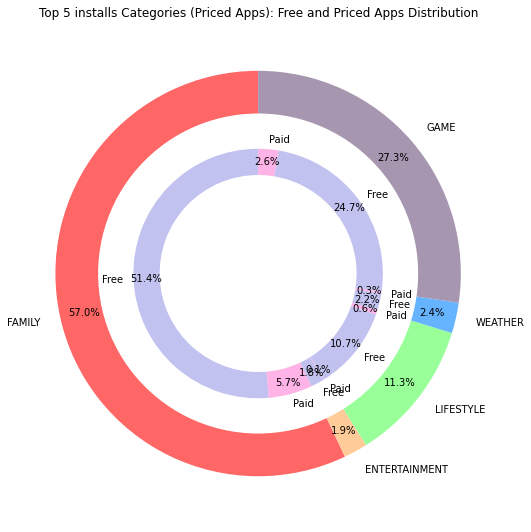

In [74]:
#free and priced app distribution for top 5 categories
arr2 = [2, 3, 0, 1, 6, 7, 8, 9, 4, 5]
arr1 = [1, 0, 3, 4, 2]

top_5_vc = google_c3[google_c3['Category'].isin(top_5_priced_ind
                                               )]['Category'].dropna().value_counts().sort_index().to_frame().iloc[arr1, 0]
labels = top_5_vc.index.values
sizes = top_5_vc.values

labels_type = ['Free', 'Paid','Free', 'Paid','Free', 'Paid','Free', 'Paid','Free', 'Paid']
sizes_type= google_c3.groupby('Category')['Type'].value_counts()[labels].sort_index().to_frame().iloc[arr2, 0]

colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff','#a796b0']
colors_type = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6','#c2c2f0','#ffb3e6',]

fig, ax = plt.subplots(figsize = (7.5,7.5))
ax.pie(sizes, labels=labels, colors=colors, startangle=90,frame=True, radius=3.25,
       autopct='%1.1f%%', pctdistance=0.88, wedgeprops=dict(width=1.3/1.9))

ax.pie(sizes_type,colors=colors_type,startangle=90,radius=2, autopct='%1.1f%%'
        ,wedgeprops=dict(width=0.8/1.9), labels = labels_type, pctdistance=0.9, 
       labeldistance = 1.08)

#Draw circle
centre_circle = plt.Circle((0,0),1.35,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.title("Top 5 installs Categories (Priced Apps): Free and Priced Apps Distribution")
plt.tight_layout()
plt.show()

Since the average price in lifestyle and family type apps are quite high, so we decide to check the price distribution

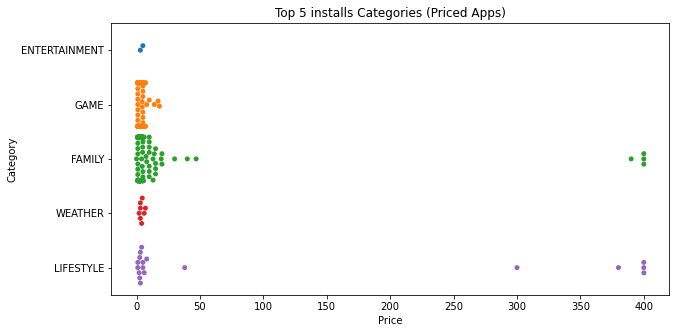

In [34]:
fig, ax = plt.subplots(figsize = (10, 5))
priced_google_top = priced_google[priced_google['Category'].isin(top_5_priced_ind)]
sns.swarmplot(data = priced_google_top, x = 'Price', y = 'Category')
plt.title('Top 5 installs Categories (Priced Apps)')
plt.show()

In [37]:
priced_google_top[priced_google_top['Price'] > 250
                 ][['App', 'Category', 'Rating', 'Size', 'Reviews', 'Price', 'Installs_num'
                   ]].sort_values('Installs_num', ascending = False).head()

,App,Category,Rating,Size,Reviews,Price,Installs_num
5351,I am rich,LIFESTYLE,3.8,1.8M,3547.0,399.99,100000.0
4362,💎 I'm rich,LIFESTYLE,3.8,26M,718.0,399.99,10000.0
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,7.3M,275.0,400.00,10000.0
5354,I am Rich Plus,FAMILY,4.0,8.7M,856.0,399.99,10000.0
5355,I am rich VIP,LIFESTYLE,3.8,2.6M,411.0,299.99,10000.0


Discovering that there are apps priced more than \$250, we took a look and found that they all included the phrase 'I am rich' in their app names and have small to moderate sizes and average rating of around 4.0.

Now we want to see if top 5 installs game categories differ for priced apps and all apps.

The common categories between top 5 categories of priced and all apps {'ENTERTAINMENT', 'GAME'}


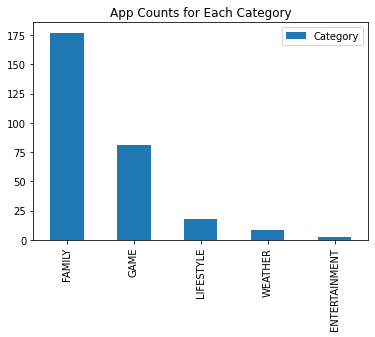

In [175]:
print(f'The common categories between top 5 categories of priced and all apps {set(top_5_priced_ind) & set(top_5_all_ind)}')


pd.DataFrame(priced_google['Category'].value_counts()[top_5_priced_ind].sort_values(ascending = False)).plot(kind = 'bar')
plt.title('App Counts for Each Category')
plt.show()

1. Apparently, 'ENTERTAINMENT' and 'GAME' are categories that people download the most no matter it is free or not.
The average price of these two categories are 3.99 and 3.47 dollars. 



We will choose 'GAME' as the category for the new developed app, since game categories have more apps than entertainment.<br>
And we will now decide the suitable price range for this new developed app.

# Find Price Range to Recommend
 - Will Price affect the number of Installs?
 - Which range of number of Installs contains most app? What is their average price?
 - What are the mean prices for high Installs?

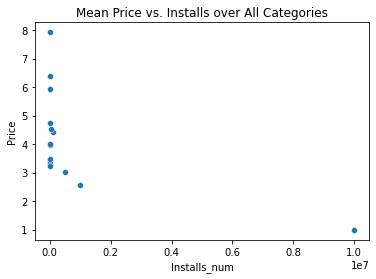

In [269]:
#priced_google_top_5 = priced_google[priced_google['Category'].isin(top_5_priced_ind)]
pv_table_pr_ins = pd.pivot_table(priced_google[priced_google['Price'] <100], index = ['Installs_num']
               , values = ['Price','Profit', 'Size_num']).sort_values('Installs_num', ascending = False).reset_index(level = 0)

sns.scatterplot(data = pv_table_pr_ins, x = 'Installs_num', y='Price')
plt.title('Mean Price vs. Installs over All Categories')
plt.show()

We can see that the higher number of installs the lower the price is.

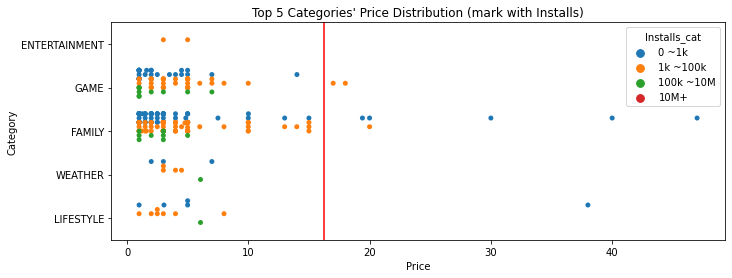

In [254]:
fig, axes = plt.subplots(figsize= (11, 4))
priced_google_dp400 = priced_google.loc[priced_google['Category'].isin(top_5_priced_ind)]
group_cat = priced_google_dp400[priced_google_dp400['Price'] <100]

sns.swarmplot(data = group_cat, y = 'Category', x = 'Price', hue = 'Installs_cat', ax= axes, dodge = True)
plt.title('Top 5 Categories\' Price Distribution (mark with Installs)')
plt.axvline(x= priced_google_dp400['Price'].mean(), c = 'red')
plt.show()

Price for GAME apps are below 20 dollars. The apps with 100k ~10M installs are below 10 dollars.  

In [264]:
#counts for each install num for game category
priced_google[(priced_google['Category'] == 'GAME')]['Installs'].value_counts().sort_values(ascending = False)

100,000+       20
1,000+         13
10,000+        12
100+            9
1,000,000+      8
50,000+         5
1+              5
5,000+          3
500+            2
500,000+        1
50+             1
10,000,000+     1
10+             1
Name: Installs, dtype: int64

In [272]:
#mean price over all categories
pv_table_pr_ins[:10]

,Installs_num,Price,Profit,Size_num
0,10000000.0,0.990000,9.900000e+06,2.900000e+07
1,1000000.0,2.578235,2.578235e+06,5.299147e+07
2,500000.0,3.040000,1.520000e+06,2.523889e+07
3,100000.0,4.441486,4.441486e+05,2.525246e+07
4,50000.0,4.538108,2.269054e+05,2.974286e+07
5,10000.0,3.960600,3.960600e+04,1.990209e+07
6,5000.0,3.267167,1.633583e+04,1.802179e+07
7,1000.0,4.734215,4.734215e+03,1.774760e+07
8,500.0,3.365500,1.682750e+03,1.480242e+07
9,100.0,4.003708,4.003708e+02,1.594428e+07


If the developer's aim is to reach 10M+ installs, then the app's price should be below 1 dollar or free. But if developer can be satisfied with installs between 100 ~ 10M+, then the recommend price range would be 2 ~4 dollars. Lastly, the size would be recommend as 26M. 

# Apple store listing
- Can an app with gaming category and price between 2~ 4 dollars survive in ios store?

<AxesSubplot:xlabel='user_rating', ylabel='Density'>

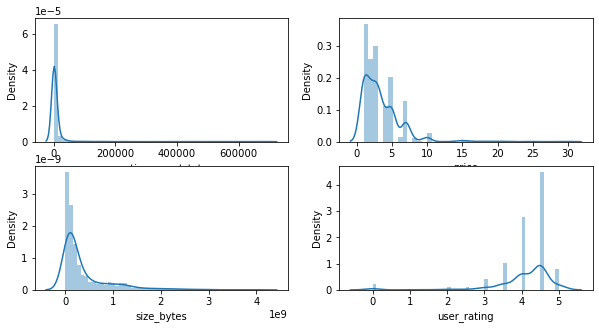

In [374]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,5))
sns.distplot(priced_apple[priced_apple['prime_genre'] == 'Games']['rating_count_tot'], ax = axes[0][0])
sns.distplot(priced_apple[priced_apple['prime_genre'] == 'Games']['price'], ax = axes[0][1])
sns.distplot(priced_apple[priced_apple['prime_genre'] == 'Games']['size_bytes'], ax = axes[1][0])
sns.distplot(priced_apple[priced_apple['prime_genre'] == 'Games']['user_rating'], ax = axes[1][1])

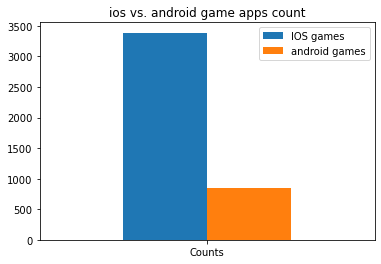

In [327]:
a_games = apple_c3[apple_c3['prime_genre'] == 'Games']['prime_genre'].count()
g_games = google_c3[google_c3['Category'] == 'GAME']['Category'].count()

pd.DataFrame([[a_games, g_games]], columns = ['IOS games', 'android games'], index = ['Counts']).plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.title("ios vs. android game apps count")
plt.show()

There are a lot less android game apps than IOS game apps.

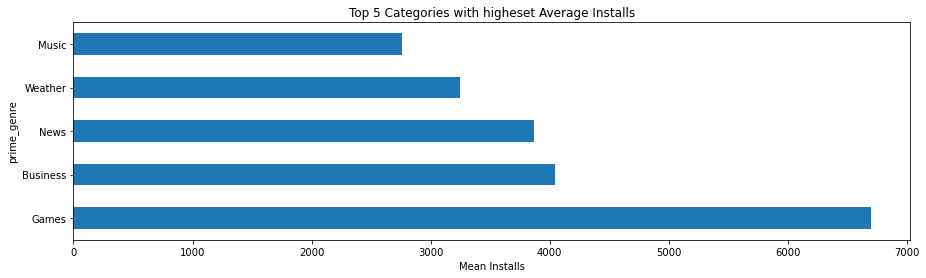

,price,rating_count_tot,size_bytes,user_rating
prime_genre,,,,
Games,3.41029,6695.863636,3.995273e+08,4.062912


In [330]:
#Find top 5 categories with highest installs
pv_table_cat_ins = pd.pivot_table(data= priced_apple, index= 'prime_genre', aggfunc = np.mean
                                 ).sort_values(['rating_count_tot'], ascending = False)
top_5_priced_ind_a = pv_table_cat_ins.index[:5].values
top_10_priced_ind_a = pv_table_cat_ins.index[:10].values

plt.figure(figsize=(15,4))
pv_table_cat_ins[:5]['rating_count_tot'].plot(kind = 'barh')
plt.xlabel("Mean Installs")
plt.title('Top 5 Categories with higheset Average Installs')
plt.show()

pv_table_cat_ins[:5].loc[['Games']]

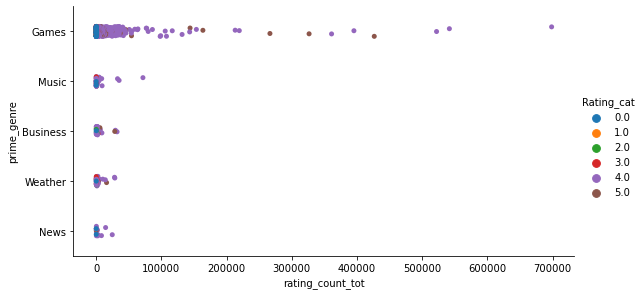

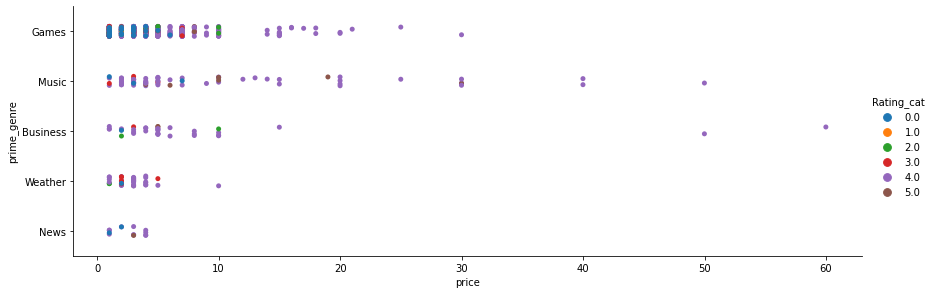

In [358]:
sns.catplot(data = priced_apple[priced_apple['prime_genre'].isin(top_5_priced_ind_a)]
             ,x = 'rating_count_tot', y = 'prime_genre', aspect =2, height = 4, hue = 'Rating_cat')

sns.catplot(data = priced_apple[priced_apple['prime_genre'].isin(top_5_priced_ind_a)]
              ,x = 'price', y = 'prime_genre', aspect =3, height = 4, hue = 'Rating_cat')

We found that the category 'Games' is also the most rated app category in ios store.<br> The price between 2~4 dollars is also a reasonable price for a game app on ios store. <br>
Therefore if the app is listed on ios store, it would also be a success.